In [1]:
import keras
from keras.layers import Dense, Input
from keras.models import Model
from keras.datasets import mnist
import numpy as np

Using TensorFlow backend.


In [2]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [3]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)

encoder = Model(input_img, encoded)

latent_input = Input(shape=(2,))
decoded = Dense(64, activation='relu')(latent_input)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

decoder = Model(latent_input, decoded)

output = decoder(encoder(input_img))

# This model maps an input to its reconstruction
autoencoder = Model(input_img, output)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


2022-03-31 16:54:38.179451: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 16:54:38.179844: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [4]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 135us/step - loss: 0.2955 - val_loss: 0.2557
Epoch 2/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.2433 - val_loss: 0.2223
Epoch 3/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.2188 - val_loss: 0.2131
Epoch 4/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.2094 - val_loss: 0.2047
Epoch 5/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.2031 - val_loss: 0.2006
Epoch 6/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.1996 - val_loss: 0.1978
Epoch 7/50
60000/60000 [==============================] - 6s 107us/step - loss: 0.1971 - val_loss: 0.1962
Epoch 8/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.1952 - val_loss: 0.1942
Epoch 9/50
60000/60000 [==============================] - 6s 108us/step - loss: 0.1933 - val_loss: 0.19

In [5]:
decoded_imgs = autoencoder.predict(x_test)

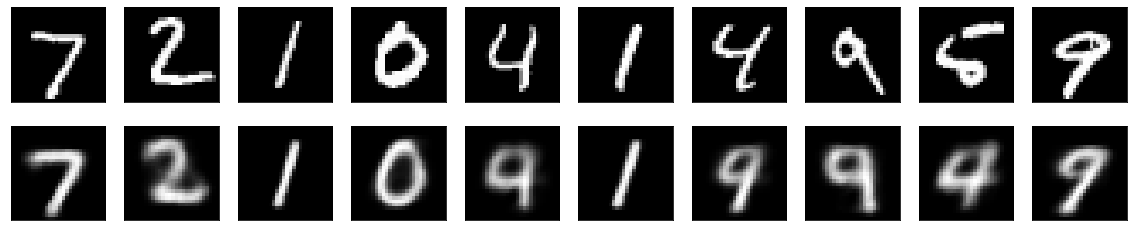

In [6]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
encoded_imgs = encoder.predict(x_test)

In [8]:
def plot_results(*args,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder, x_test, y_test = args
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.savefig(filename)

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)

ValueError: The number of FixedLocator locations (31), usually from a call to set_ticks, does not match the number of ticklabels (30).

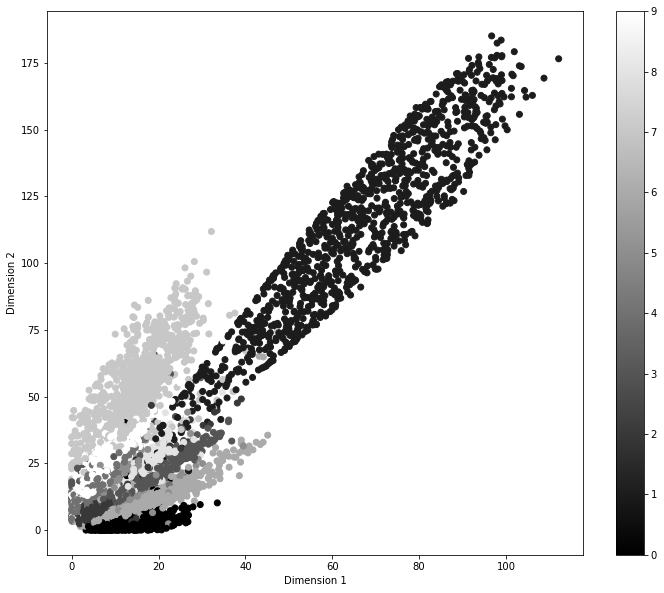

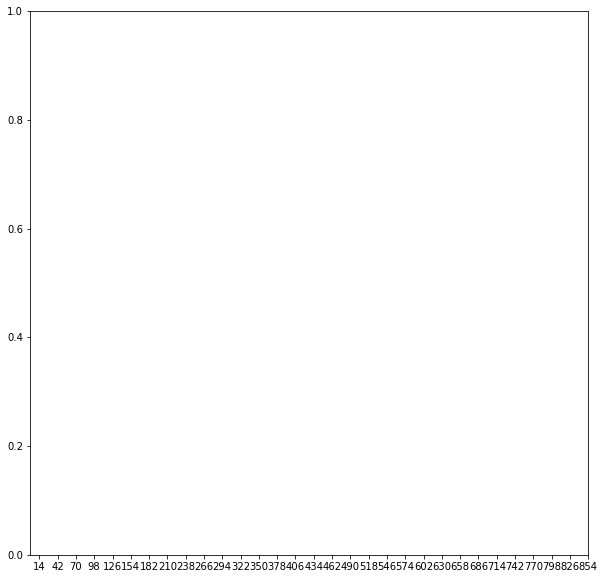

In [9]:
import os
plot_results(encoder, decoder, x_test, y_test)